In [17]:
#Load libraries
import os
import numpy as np
import pandas as pd
from ast import literal_eval
from tqdm import tqdm
import random
import tensorflow as tf
import re
import matplotlib
from matplotlib import pyplot as plt
import sys
import copy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer, Reshape
from sklearn.metrics import roc_curve, auc, average_precision_score, matthews_corrcoef, f1_score, precision_score


In [18]:
#Add your PTM amino acids
PR="S"
PR2="T"
sym="@"
sym2="&"
#If only have modification at one site then leave PR2 and sym2 blank i.e. ""
#Add folder
folder=f"Example_data"

In [67]:
#Specify a reference proteome and generate dictionay

######################################################################################################################
#
#Reference proteome should contain sequences for all the proteins in your dataset. In the case of an organism specific dataset
#it could also be useful to have all the proteins for the organism. 

file_name='20240529_Ref_seq_Blazev.fasta' #This is an example reference proteome which contains all human proteins in their common isoform. 

#Reference proteome should be in FASTA format in a text file, where the name for each sequence is: >sp|UniprotID|Mnemonic_ID opt_info
#Refernece proteomes or ID mappings of Uniprot IDs (esp. if using multiple organism proteins) are easy to get off of Uniprot

df = pd.read_csv(file_name, sep='delimiter', header=None)

#Load all possible Uniprot IDs from reference proteome
df.fillna("NA", inplace=True) # just in case any "NA" got turned into NaNs
ID_df = df[df[0].str.contains(">")][0]
ID_list = []
for i in range(len(ID_df)):
    ID_list.append(ID_df.iloc[i].split("|")[1]) #Change to index 2 if using Mnemonic_ID instead of UniprotID
ID_array = np.array(ID_list)
print("ID array has been made!")

#Makes array of sequences
sequences = []
indices_of_uniprot_ids = list(df[df[0].str.contains(">")].index)
for i in range(len(indices_of_uniprot_ids)-1):
    # concatenate all into one string
    sequences.append(df[indices_of_uniprot_ids[i]+1:indices_of_uniprot_ids[i+1]][0].sum())
    if i == len(indices_of_uniprot_ids)-2:
        sequences.append(df[indices_of_uniprot_ids[i+1]+1:][0].sum())
sequences = np.array(sequences)
print("Lines have been separated!")

# Creates dictionary that maps Uniprot ID to sequence
pairs = zip(ID_array, sequences)
protein_dict = {A:B for A,B in pairs}
print("protein_dict has been made!")

C:\Users\Clair\AppData\Local\Temp\ipykernel_5412\2230625363.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_name, sep='delimiter', header=None)


ID array has been made!
Lines have been separated!
protein_dict has been made!


In [66]:
#Specify known sites of modification
#See example excel sheet for format
excel_sheet="20240529_Blazev_2022_excercise_dataset.xlsx"

sheet = pd.read_excel(excel_sheet, sheet_name='Spre')
Data=sheet[["Uniprot ID", "Position"]]

IDs=Data.iloc[:, 0] 
IDs=IDs.to_numpy(dtype=str)

Position=Data.iloc[:, 1] 
Position=Position.to_numpy(dtype=int)

C:\Users\Clair\anaconda3\envs\tf\lib\site-packages\pandas\core\base.py:662: RuntimeWarning: invalid value encountered in cast
  result = np.asarray(values, dtype=dtype)


In [68]:
PR_site_array=[]
PR2_site_array=[]
for i in tqdm(range(len(IDs)), desc="Loading...", position=0, leave=True):
    ID=IDs[i]
    location=int(Position[i])
    try:
        seq=protein_dict[ID]
        if location > len(seq): #Will not add to list of kmers
            print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
            print (ID)
            newseq=seq
        elif seq[location-1] == PR or seq[location-1]==sym:
            PR_site_array.append ((ID, location))
            newseq=seq[:location-1] + sym + seq[location:]
        elif PR2 != "":
            if seq[int(location-1)] == PR2 or seq[int(location-1)]==sym2:
                PR2_site_array.append ((ID, location))
                newseq=seq[:location-1] + sym2 + seq[location:]
        else:
            print(seq[location-1])
            print ("Sequence key error for "+ID+" at " + str(location)) #Will not add it to list of sites or dictionary
            newseq=seq
    except KeyError:
        print(ID+" not in protein_dict")    
    protein_dict.update({ID: newseq})

Loading...: 100%|██████████████████████████████████████████████████████████████| 8284/8284 [00:00<00:00, 129933.38it/s]

H7BXK9 not in protein_dict
A0A0A0MRL6 not in protein_dict
Site outside of seq bounds, site: 458, sequnce length: 455
A0A0A0MRL6
Site outside of seq bounds, site: 608, sequnce length: 455
A0A0A0MRL6
Site outside of seq bounds, site: 623, sequnce length: 455
A0A0A0MRL6
Site outside of seq bounds, site: 470, sequnce length: 455
A0A0A0MRL6
A0A087X0W7 not in protein_dict
A0A087X1U1 not in protein_dict
M0QYL4 not in protein_dict
Site outside of seq bounds, site: 1390, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1394, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1401, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1406, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1424, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1855, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 1865, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 430, sequnce length: 383
Q96L96
Site outside of seq bounds, site: 658,

In [69]:
#Now we need a list of all the S and T sites in the Uniprot file
#These will be the negatives as the positives have been been changed from PR, PR2 to sym, sym2 so they won't appear
print (protein_dict['Q2M2I8'])
PR_list=[]
PR2_list=[]
for key in protein_dict:
    seq=protein_dict[key]
    for match in re.finditer(PR, seq):
        PR_list.append((key, match.start()+1))

print ("Number of PR sites: "+str(len(PR_list)))
np.save(f'{folder}/All_PR_sites', PR_list)
print ("PR sites saved")

#!!!!!!!!
#Don't do if there is no PR2 site
for key in protein_dict:
    #print (key)
    seq=protein_dict[key]
    for matchPR2 in re.finditer(PR2, seq):
        PR2_list.append((key, matchPR2.start()+1))
        #print (matchT.start()+1)

print ("Number of PR2 sites: "+str(len(PR2_list)))
np.save(f'{folder}/All_PR2_sites', PR2_list)
print ("PR2 sites saved")

MKKFFDSRREQGGSGLGSGS@GGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQ&&PPPAVQGQKVGSL&PPS@PKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLP@QTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL
Number of PR sites: 335259
PR sites sa

In [51]:
################################
#Various functions to define
###############################

#Define function to make kmer from a location and sequence
def ndtolot (ndarray):
    """
    converts 2D ndarray (n, 2) to a list of tuples
    """
    list=[]
    for i in range (0, len(ndarray[:, 0])):
        holding=(ndarray[i, 0], int(ndarray[i, 1]))
        list.append(holding)
    return list

def kmer_from_site(seq, location, k=53):
    """
    Returns kmer of length k from a location and sequence. Ends are padded with "-"

    """
    half=int((k-1)/2)
    if location > len(seq): #Will not add to list of kmers
        print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
        kmer=''
    elif location <= half: #To deal with sites near the n terminus
        if location > len(seq)-half: #To deal with sequences shorter than k
            gap="-"*(half-location+1)
            gap2="-"*int(half-(len(seq)-location))
            kmer=seq[0 : int(location+half)]
            kmer=gap+kmer+gap2
        else: 
            gap="-"*(half-location+1)
            kmer=seq[0 : int(location+half)]
            kmer=gap+kmer
    elif location > len(seq)-half: #To deal with sites near the C terminus
        gap="-"*int(half-(len(seq)-location))
        kmer=seq[int(location-half-1): len(seq)]
        kmer=kmer+gap
    else:
        kmer=seq[int(location-half-1): int(location+half)]
    return kmer
    
#Define function to make positive and negative kmers
def make_kmers(protein_dict, PR_sites, PR2_sites, k=53):
    """
    Makes positive and negative kmers (with known PTM locations) for a list of sites
    Can have up to two site lists for modifications at 2 different amino acids: PR_sites and PR2_sites, PR2_sites can be empty
        -Site lists must be a list of tuples of the form (ID, site) where site is the bio indexing (starts from 1)
    Protein_dict: dictionary of UniprotIDs with the sequences as keys
    k: length of kmer, default is 53
    There must be files
    """
    pos_sites=PR_sites+PR2_sites
    pos_kmers=[]
    neg_kmers=[]

    nPR=ndtolot(np.load(f'{folder}/All_PR_sites.npy', allow_pickle=True))
    print (nPR)
    nPR2=ndtolot(np.load(f'{folder}/All_PR2_sites.npy', allow_pickle=True))

    neg_PR_sites= random.sample(nPR, len(PR_sites))
    neg_PR2_sites= random.sample(nPR2, len(PR2_sites))

    neg_sites=neg_PR_sites+neg_PR2_sites
    print (len(neg_sites))
    print (len(pos_sites))
    
    for i in range(0, len(pos_sites)):
        ID=pos_sites[i][0]
        location=pos_sites[i][1]
        seq=protein_dict[ID]
        kmer=kmer_from_site(seq, location, k=k)
        if location > len(seq): #Will not add to list of kmers
            print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
        elif seq[int(location-1)] == PR or seq[int(location-1)]==sym:
            pos_kmers.append(kmer)
        elif seq[int(location-1)] == PR2 or seq[int(location-1)]==sym2:
            pos_kmers.append(kmer)
        else:
            print(seq[int(location-1)])
            print ("Sequence key error for "+ID+" at " + str(location)) #Will not add it to list of kmers because doesn't match uniprot
                #raise Exception("Sequence key error for "+ID+" at " + str(location))
        if len(kmer) != k:
            print (kmer)
            print (len(kmer))

    for i in range(0, len(neg_sites)):
        ID=neg_sites[i][0]
        location=neg_sites[i][1]
        print (ID)
        seq=protein_dict[ID]
        kmer=kmer_from_site(seq, location, k=k)
        if location > len(seq): #Will not add to list of kmers
            print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
        elif seq[int(location-1)] == PR or seq[int(location-1)]==sym:
            neg_kmers.append(kmer)
        elif seq[int(location-1)] == PR2 or seq[int(location-1)]==sym2:
            neg_kmers.append(kmer)
        else:
            print(seq[int(location-1)])
            print ("Sequence key error for "+ID+" at " + str(location)) #Will not add it to list of kmers because doesn't match uniprot
                #raise Exception("Sequence key error for "+ID+" at " + str(location))
        if len(kmer) != k:
            print (kmer)
            print (len(kmer))
    
    return pos_kmers, neg_kmers     

def unlabeling (kmers):
    """
    Removes sym and sym2 from kmers to make dataset without PTM locations
    """
    new_kmers=[]
    for kmer in kmers:
        new_kmer=kmer.replace(sym, PR).replace(sym2,PR2)
        new_kmers.append(new_kmer)
    return new_kmers

def unlabel_center (kmers, k=53):
    """
    Removes sym and sym2 from kmer center
    """
    new_kmers=[]
    half=int((k-1)/2)
    for kmer in kmers:
        if kmer[half] == sym:
            new_kmer=kmer[:half]+PR+kmer[half+1:]
        elif kmer[half] == sym2:
            new_kmer=kmer[:half]+PR2+kmer[half+1:]
        else:
            new_kmer=kmer
        assert len(new_kmer)==k
        new_kmers.append(new_kmer)
    
    return new_kmers

def convert_to_onehot(data, alphabet):
    #Creates a dict, that maps to every char of alphabet an unique int based on position
    global char_to_int
    char_to_int = dict((c,i) for i,c in enumerate(alphabet))
    encoded_data = []
    #Replaces every char in data with the mapped int
    encoded_data.extend([char_to_int[char] for char in data])
    return encoded_data

def tensor_encoding(x_data, depth, type, alphabet):
    indices = []
    t2 = []
    for i in tqdm(range(len(x_data))):
        indices.append(convert_to_onehot(x_data[i,0], alphabet))
        if len(convert_to_onehot(x_data[i,0], alphabet)) != 53:
            print (x_data[i,0])
            print ("Length off")
    array=np.stack(indices, axis=0)
    if type == 'emb':
        return array
    for i in tqdm(range(len(indices))):
        t1 = tf.one_hot(indices[i], depth) # output: [9 x 23]
        t2.append(t1)
    return t2

def make_datasets_train_models (protein_dict, PR_sites, PR2_sites, trial_num, k=53, folder=folder):
    """
    Given a protein_dict that has been labeled with PTM sites and a list of sites it will make test, train, and val datasets and train a simple CNN 
    model

    Datasets and models are saved in specified folder
    """
    #Make kmers
    lpos_kmers, lneg_kmers=make_kmers(protein_dict, PR_site_array, PR2_site_array, k=k)
    lpos_kmers, lneg_kmers=unlabel_center(lpos_kmers, k=k), unlabel_center(lneg_kmers, k=k)
    pos_kmers, neg_kmers=unlabeling(lpos_kmers), unlabeling (lneg_kmers)

    y_pos=np.ones((len(pos_kmers)), dtype=np.int32)
    y_neg=np.zeros((len(neg_kmers)), dtype=np.int32)

    pos_kmers=np.array(pos_kmers)
    neg_kmers=np.array(neg_kmers)
    lpos_kmers=np.array(lpos_kmers)
    lneg_kmers=np.array(lneg_kmers)
    
    pos_k = np.stack((pos_kmers, y_pos), axis=1)
    neg_k = np.stack((neg_kmers, y_neg), axis=1)
    lpos_k = np.stack((lpos_kmers, y_pos), axis=1)
    lneg_k = np.stack((lneg_kmers, y_neg), axis=1)

    full= np.vstack([pos_k,neg_k])
    lfull = np.vstack([lpos_k,lneg_k])
    np.random.shuffle(full)
    np.random.shuffle(lfull)

    print (full[:, 1].dtype)
    #print (np.shape(full))
    #print (np.shape(lfull))

    x_data, y_data = np.split(full, 2, axis=1)
    x_datal, y_datal = np.split(lfull, 2, axis=1)

    #print (np.shape(x_datal))
    y_data=y_data.astype(np.int32)
    y_datal=y_datal.astype(np.int32)
    #print (y_data.dtype)
    #print (y_data)

    # Split into train, validation, and test datasets
    N = len(full)
    x_train = x_data[0:int(0.8*N), :]
    #print (x_train)
    y_train = y_data[0:int(0.8*N)]
    #print (y_train)

    x_validation = x_data[int(0.8*N):int(0.8*N)+int(0.1*N), :]
    y_validation = y_data[int(0.8*N):int(0.8*N)+int(0.1*N)]

    x_test = x_data[int(0.8*N)+int(0.1*N):, :]
    y_test = y_data[int(0.8*N)+int(0.1*N):]

    x_trainl = x_datal[0:int(0.8*N), :]
    y_trainl = y_datal[0:int(0.8*N)]

    x_validationl = x_datal[int(0.8*N):int(0.8*N)+int(0.1*N), :]
    y_validationl = y_datal[int(0.8*N):int(0.8*N)+int(0.1*N)]

    x_testl = x_datal[int(0.8*N)+int(0.1*N):, :]
    y_testl = y_datal[int(0.8*N)+int(0.1*N):]

    #Make tensors of x data
    tensor1 = tensor_encoding(x_train, 23, 'emb', alphabet_without_labels)
    tensor2 = tensor_encoding(x_validation, 23, 'emb', alphabet_without_labels)
    tensor3 = tensor_encoding(x_test, 23, 'emb', alphabet_without_labels)
    tensor4 = tensor_encoding(x_trainl, 23, 'emb', alphabet_with_labels)
    tensor5 = tensor_encoding(x_validationl, 23, 'emb', alphabet_with_labels)
    tensor6 = tensor_encoding(x_testl, 23, 'emb', alphabet_with_labels)

    print (type(tensor1))
    print (tensor1.dtype)
    print (y_train.dtype)
    #print (np.shape(tensor2))
    #print (np.shape(tensor3))
    #print (np.shape(tensor4))
    #print (np.shape(tensor5))
    #print (np.shape(tensor6))

    directory = f"Trial{trial_num}"
    parent_dir = folder+'/'
    path = os.path.join(parent_dir, directory) 
    try:
        os.mkdir(path) 
    except:
        pass
    
    #Save datasets
    np.save(f'{path}/x_train_no_labels_{trial_num}', tensor1)
    np.save(f'{path}/y_train_no_labels_{trial_num}', y_train)
    np.save(f'{path}/x_validation_no_labels_{trial_num}', tensor2)
    np.save(f'{path}/y_validation_no_labels_{trial_num}', y_validation)
    np.save(f'{path}/x_test_no_labels_{trial_num}', tensor3)
    np.save(f'{path}/y_test_no_labels_{trial_num}', y_test)
    np.save(f'{path}/x_train_with_labels_{trial_num}', tensor4)
    np.save(f'{path}/y_train_with_labels_{trial_num}', y_trainl)
    np.save(f'{path}/x_validation_with_labels_{trial_num}', tensor5)
    np.save(f'{path}/y_validation_with_labels_{trial_num}', y_validationl)
    np.save(f'{path}/x_test_with_labels_{trial_num}', tensor6)
    np.save(f'{path}/y_test_with_labels_{trial_num}', y_testl)

    #Add the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

    model = Sequential()
    model.add(Embedding(input_dim=256, output_dim=21, embeddings_initializer={'class_name': 'RandomUniform',
         'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, input_length=53, name="emb_layer"))
    model.add(Reshape((53, 21, 1), input_shape=(53, 21)))
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=(53, 21, 1), activation='relu', kernel_regularizer=l2(1e-06)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer=Adam(1e-03), 
                  loss='BinaryCrossentropy', 
                  metrics=['accuracy'])
    history = model.fit(x=tensor1,y=y_train,
              batch_size=100, epochs=400,
              validation_data=(tensor2, y_validation), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/emb_CNN_no_labels_{trial_num}.h5')
    model.evaluate(tensor3, y_test)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    pred = model.predict(tensor3).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("Without labels")
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print("AUC:", round(auc(fpr, tpr), 4))
    print("AUPRC:", round(average_precision_score(y_test, pred), 4))
    pred2 = (pred > 0.5)
    pred2 = np.array(pred2)
    pred2 = pred2.astype(int)
    print("MCC:", round(matthews_corrcoef(y_test, pred2), 4))
    print("F1:", round(f1_score(y_test, pred2), 4))
    print("Sensitivity:", round(np.average(tpr), 4))
    print("Specificity:", round(np.average(1-fpr), 4))
    print("Precision:", round(precision_score(y_test, pred2), 4))

    #Now with labels
    historyl = model.fit(x=tensor4,y=y_trainl,
              batch_size=100, epochs=400,
              validation_data=(tensor5, y_validationl), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/emb_CNN_with_labels_{trial_num}.h5')
    model.evaluate(tensor6, y_testl)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    predl = model.predict(tensor6).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("With labels")
    fprl, tprl, thresholdsl = roc_curve(y_testl, predl)
    print("AUC:", round(auc(fprl, tprl), 4))
    print("AUPRC:", round(average_precision_score(y_testl, predl), 4))
    pred2l = (predl > 0.5)
    pred2l = np.array(pred2l)
    pred2l = pred2l.astype(int)
    print("MCC:", round(matthews_corrcoef(y_testl, pred2l), 4))
    print("F1:", round(f1_score(y_testl, pred2l), 4))
    print("Sensitivity:", round(np.average(tprl), 4))
    print("Specificity:", round(np.average(1-fprl), 4))
    print("Precision:", round(precision_score(y_testl, pred2l), 4))

    
    

In [57]:
alphabet_with_labels = "ARNDCEQGHILKMFPSTWYV@&-UX" 
alphabet_without_labels = "ARNDCEQGHILKMFPSTWYV-UX"

for trial_num in range(1, 11):
    make_datasets_train_models (protein_dict, PR_site_array, PR2_site_array, trial_num, k=53, folder=f'{folder}/PostSprint')

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 43835.97it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_12 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 3600)              0         
                                                                 
 dense_24 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 21145.33it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_13 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 3600)              0         
                                                                 
 dense_26 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 41569.34it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_14 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 3600)              0         
                                                                 
 dense_28 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 38280.48it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_15 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 3600)              0         
                                                                 
 dense_30 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 36810.34it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_16 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 3600)              0         
                                                                 
 dense_32 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 32681.84it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_17 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 3600)              0         
                                                                 
 dense_34 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 43269.07it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_18 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_18 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 3600)              0         
                                                                 
 dense_36 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 42010.31it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_19 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 3600)              0         
                                                                 
 dense_38 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 28834.80it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_20 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 3600)              0         
                                                                 
 dense_40 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7327
7327
A
Sequence key error for A0A0A0MRL6 at 313
D
Sequence key error for A0A0A0MRL6 at 323
K
Sequence key error for Q9Y2D5 at 393
L
Sequence key error for Q9Y2Q0-3 at 1111
I
Sequence key error for Q9Y2Q0-3 at 29
A
Sequence key error for P47756 at 182
K
Sequence key error for P47756 at 245
P
Sequence key error for A0A2R8Y6G6 at 141
G
Sequence key error for A0A2R8Y6G6 at 27
P
Sequence key error for H0Y7W6 at 258
L
Sequence key error for P49841 at 219
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key error for P12882 at 1340
E
Sequence key error for P12882 at 1542
E
Sequence key error for P12882 at 1554
D
Sequence key error f

100%|███████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 32337.05it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_21 (Reshape)        (None, 53, 21, 1)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 9, 16)        0         
 g2D)                                                            
                                                                 
 flatten_21 (Flatten)        (None, 3600)              0         
                                                                 
 dense_42 (Dense)            (None, 32)                115232    
                 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



7499
7499
E
Sequence key error for E9PCT3 at 18
L
Sequence key error for E9PCT3 at 36
G
Sequence key error for A0A2R8Y6G6 at 141
V
Sequence key error for A0A2R8Y6G6 at 254
L
Sequence key error for A0A2R8Y6G6 at 263
P
Sequence key error for A0A2R8Y6G6 at 27
F
Sequence key error for A0A2R8Y6G6 at 272
A
Sequence key error for A0A2R8Y6G6 at 419
L
Sequence key error for P49841 at 219
D
Sequence key error for O75112-2 at 112
Q
Sequence key error for Q9UKX2 at 1043
Q
Sequence key error for P12882 at 1069
E
Sequence key error for P12882 at 1092
L
Sequence key error for P12882 at 1096
K
Sequence key error for Q9UKX2 at 1134
L
Sequence key error for Q9UKX2 at 1146
V
Sequence key error for Q9UKX2 at 1164
L
Sequence key error for P12882 at 1237
Q
Sequence key error for P12882 at 1261
E
Sequence key error for P12882 at 1292
L
Sequence key error for P12882 at 1303
Q
Sequence key error for P12882 at 1306
A
Sequence key error for P12882 at 1331
L
Sequence key error for P12882 at 1339
Q
Sequence key er

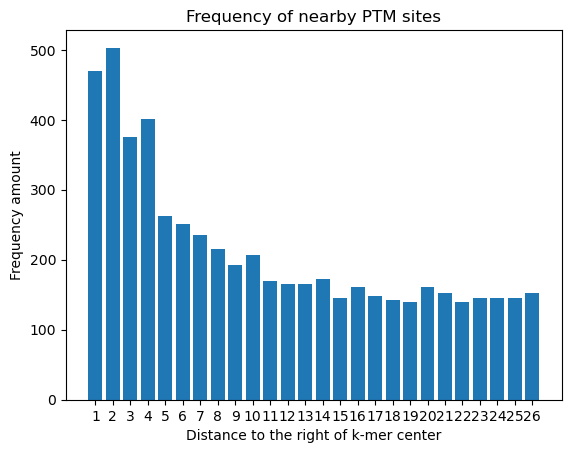

array([[  1, 470],
       [  2, 503],
       [  3, 375],
       [  4, 401],
       [  5, 262],
       [  6, 251],
       [  7, 235],
       [  8, 216],
       [  9, 192],
       [ 10, 207],
       [ 11, 170],
       [ 12, 165],
       [ 13, 165],
       [ 14, 172],
       [ 15, 145],
       [ 16, 161],
       [ 17, 148],
       [ 18, 142],
       [ 19, 140],
       [ 20, 161],
       [ 21, 152],
       [ 22, 140],
       [ 23, 146],
       [ 24, 145],
       [ 25, 146],
       [ 26, 153]])

In [70]:
def frequency_graph(kmers, model, k=53):
    """

    Parameters
    ----------
    k : int
        an odd number that specifies that length of the kmer with the
        phosphorylation site in the middle
    kmer : 2D array
        1D array with kmers

    model: Title for graph
    Returns
    -------
    frequencies : 2D array
        2D array with columns distance away from center kmer PTM and 
        frequency of nearby PTMS

    """
    around_ind = k//2
    x=0
    z=0
    frequencies = {}
    for i in range(0, len(kmers)):
        if "@" in kmers[i]:
            x+=1
        elif "&" in kmers[i]:
            z+=1
        temp = kmers[i][around_ind+1:]
        for j in range(len(temp)):
            if "@" == temp[j]:
                if j+1 in frequencies.keys():
                    frequencies[j+1] += 1
                else:
                    frequencies[j+1] = 1
            elif "&" ==temp[j]:
                if j+1 in frequencies.keys():
                    frequencies[j+1] += 1
                else:
                    frequencies[j+1] = 1        
        
    
    frequencies = list(frequencies.items())
    frequencies = np.array(frequencies)
    print (frequencies)
    frequencies = frequencies[frequencies[:,0].argsort()]

    plt.figure(0)
    plt.bar(frequencies[:,0], frequencies[:,1])
    plt.xticks(frequencies[:,0])
    plt.title("Frequency of nearby PTM sites")
    plt.ylabel("Frequency amount")
    plt.xlabel("Distance to the right of k-mer center")
    plt.savefig(model+"_frequencies.pdf", transparent=True)
    plt.show()

    return frequencies


lpos_kmers, lneg_kmers=make_kmers(protein_dict, PR_site_array, PR2_site_array)
frequency_graph (lpos_kmers, model=f'{folder}/PreSprint')
    

NameError: name 'Enum' is not defined